# Sprint 11. Tasca 01. Unsupervised learning. Clustering
## By José Manuel Castaño

## - Exercici 1

#### Agrupa els diferents vols utilitzant l'algorisme de K-means.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, AgglomerativeClustering
from kneed import KneeLocator
import scipy.cluster.hierarchy as shc

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [2]:
airlines = pd.read_csv('DelayedFlights.csv', index_col=0, engine='python')

In [3]:
airlines

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,335,N712SW,128.0,150.0,116.0,-14.0,8.0,IAD,TPA,810,4.0,8.0,0,N,0,NaN,NaN,NaN,NaN,NaN
1,2008,1,3,4,754.0,735,1002.0,1000,WN,3231,N772SW,128.0,145.0,113.0,2.0,19.0,IAD,TPA,810,5.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN
2,2008,1,3,4,628.0,620,804.0,750,WN,448,N428WN,96.0,90.0,76.0,14.0,8.0,IND,BWI,515,3.0,17.0,0,N,0,NaN,NaN,NaN,NaN,NaN
4,2008,1,3,4,1829.0,1755,1959.0,1925,WN,3920,N464WN,90.0,90.0,77.0,34.0,34.0,IND,BWI,515,3.0,10.0,0,N,0,2.0,0.0,0.0,0.0,32.0
5,2008,1,3,4,1940.0,1915,2121.0,2110,WN,378,N726SW,101.0,115.0,87.0,11.0,25.0,IND,JAX,688,4.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7009710,2008,12,13,6,1250.0,1220,1617.0,1552,DL,1621,N938DL,147.0,152.0,120.0,25.0,30.0,MSP,ATL,906,9.0,18.0,0,N,0,3.0,0.0,0.0,0.0,22.0
7009717,2008,12,13,6,657.0,600,904.0,749,DL,1631,N3743H,127.0,109.0,78.0,75.0,57.0,RIC,ATL,481,15.0,34.0,0,N,0,0.0,57.0,18.0,0.0,0.0
7009718,2008,12,13,6,1007.0,847,1149.0,1010,DL,1631,N909DA,162.0,143.0,122.0,99.0,80.0,ATL,IAH,689,8.0,32.0,0,N,0,1.0,0.0,19.0,0.0,79.0
7009726,2008,12,13,6,1251.0,1240,1446.0,1437,DL,1639,N646DL,115.0,117.0,89.0,9.0,11.0,IAD,ATL,533,13.0,13.0,0,N,0,NaN,NaN,NaN,NaN,NaN


La descripción de los diferentes campos, el estudio de la distribución de las variables, los Nans, etc, ya lo hemos realizado en exercicios anteriores. 

Elimimamos del data set los vuelos cancelados y los desviados ya que son vuelos que no se han producido o que al haber sido desviados las variables no son comparables con el resto.

In [3]:
airlines=airlines[airlines['Cancelled']==0]
airlines=airlines[airlines['Diverted'] ==0]

### Eliminación de variables

En este primer modelo, eliminamos algunas variables por diferentes motivos:
    
- **Cancelled, CancellationCode, Diverted** porque hemos eliminado los vuelos cancelados y desviados
- **CarrierDelay, WeatherDelay, NASDelay, SecurityDelay, SecurityDelay, LateAircraftDelay** ya que suman **DepDelay** para los vuelos que DepDelay >15'. Quizás se han registrado cuando ya se conoce el retraso y se han cuadrado exactamente con el retraso. Nos quedamos con **DepDelay**
- **AirTime, TaxiIn, TaxiOut** ya que ActualElapsedTime = AirTime + TaxiIn + TaxiOut. Nos quedamos con **ActualElapsedTime**
- **FlightNum, TailNum** porque entendemos que tienen poca influencia y además incrementaria mucho el data set si las dummificamos.
- **Year** perque siempre es 2008
- **DepTime, ArrTime, CRSArrTime**. Nos quedemos **CRSDepTime** como variable de horario y con **CRSElapsedTime** como variable de tiempo
- **UniqueCarrier, Origin, Dest** Son variables que habría que dummificar y al tener muchos valores únicos, harían costoso el procesado y además harían muy complejo el clustering

En función de los resultados de los modelos, quizás volveríamos a recuperar algunas de las variables inicialmente rechazadas.


In [4]:
airlines1=airlines.drop(['Cancelled', 'CancellationCode', 'Diverted','CarrierDelay','WeatherDelay', 'NASDelay', 'SecurityDelay', 'SecurityDelay', 'LateAircraftDelay','AirTime', 'TaxiIn', 'TaxiOut','FlightNum','TailNum', 'Year','DepTime', 'ArrTime', 'CRSArrTime', 'UniqueCarrier', 'Origin', 'Dest'], axis=1)
airlines1

,Month,DayofMonth,DayOfWeek,CRSDepTime,ActualElapsedTime,CRSElapsedTime,ArrDelay,DepDelay,Distance
0,1,3,4,1955,128.0,150.0,-14.0,8.0,810
1,1,3,4,735,128.0,145.0,2.0,19.0,810
2,1,3,4,620,96.0,90.0,14.0,8.0,515
4,1,3,4,1755,90.0,90.0,34.0,34.0,515
5,1,3,4,1915,101.0,115.0,11.0,25.0,688
...,...,...,...,...,...,...,...,...,...
7009710,12,13,6,1220,147.0,152.0,25.0,30.0,906
7009717,12,13,6,600,127.0,109.0,75.0,57.0,481
7009718,12,13,6,847,162.0,143.0,99.0,80.0,689
7009726,12,13,6,1240,115.0,117.0,9.0,11.0,533


Transformamos **CRSDepTime** en intervalos horarios

In [5]:
airlines1['CRSDepTime'] = airlines1['CRSDepTime'] //100

Aplicaremos **PCA** al data set airlines1.  
Previamente les aplicamos un escalado con:
- **StandardScaler** para CRSDepTime, ActualElapsedTime, CRSElapsedTime, ArrDelay, DepDelay, Distance ya que presentan muchos outliers.
- **MinMaxScaler** para Month, DayofMonth, DayOfWeek

In [6]:
#Escalamos con el MinMaxScaler y StandardScaler
columnas_standard= ['CRSDepTime', 'ActualElapsedTime', 'CRSElapsedTime', 'ArrDelay', 'DepDelay', 'Distance']
columnas_minmax= ['Month', 'DayofMonth', 'DayOfWeek']
x_minmax= MinMaxScaler().fit_transform(airlines1[columnas_minmax])
x_standard= StandardScaler().fit_transform(airlines1[columnas_standard])
airlines1_pca= pd.DataFrame(np.concatenate((x_minmax, x_standard), axis=1), columns = (columnas_minmax + columnas_standard))
airlines1_pca

,Month,DayofMonth,DayOfWeek,CRSDepTime,ActualElapsedTime,CRSElapsedTime,ArrDelay,DepDelay,Distance
0,0.0,0.066667,0.500000,1.083616,-0.073631,0.221839,-0.989701,-0.658801,0.078502
1,0.0,0.066667,0.500000,-1.743881,-0.073631,0.151647,-0.707935,-0.452290,0.078502
2,0.0,0.066667,0.500000,-1.979506,-0.517705,-0.620463,-0.496611,-0.658801,-0.435537
3,0.0,0.066667,0.500000,0.612366,-0.600969,-0.620463,-0.144403,-0.170685,-0.435537
4,0.0,0.066667,0.500000,1.083616,-0.448319,-0.269504,-0.549442,-0.339648,-0.134084
...,...,...,...,...,...,...,...,...,...
1928366,1.0,0.400000,0.833333,-0.565757,0.190038,0.249916,-0.302896,-0.245780,0.245783
1928367,1.0,0.400000,0.833333,-1.979506,-0.087508,-0.353734,0.577622,0.261110,-0.494783
1928368,1.0,0.400000,0.833333,-1.508256,0.398198,0.123570,1.000271,0.692906,-0.132341
1928369,1.0,0.400000,0.833333,-0.565757,-0.254036,-0.241427,-0.584662,-0.602480,-0.404172


In [7]:
#Aplicamos el PCA
pca = PCA(0.95)
x_pca = pca.fit_transform(airlines1_pca)
num_var = pca.n_components_                     #Calculo en nº de componentes
var_pca=[f'PCA_{i}' for i in range(num_var)]    #Creo los nombres de los componentes

x_pca=pd.DataFrame(x_pca, columns=var_pca)      
x_pca

,PCA_0,PCA_1,PCA_2,PCA_3
0,0.085418,-1.085423,-1.179350,0.051700
1,0.124714,-0.958130,1.666751,0.023882
2,-0.868173,-0.956573,1.934883,0.032983
3,-0.976243,-0.166548,-0.603174,0.055028
4,-0.529655,-0.544812,-1.120215,0.050632
...,...,...,...,...
1928366,0.406093,-0.435792,0.521136,-0.361811
1928367,-0.478586,0.455716,2.037375,-0.356782
1928368,0.282598,1.086984,1.593309,-0.347908
1928369,-0.515288,-0.870099,0.513562,-0.356430


Comprobamos que con **4 componentes** explicamos el 95% de la varianza. Nos quedamos con estos 4 componentes.

Vemos las variables que explican cada uno de los componentes PCA

In [8]:
variables_pca = pd.DataFrame({'Variables' : (columnas_minmax + columnas_standard), 'PCA_0': pca.components_[0], 'PCA_1': pca.components_[1], 
                              'PCA_2':pca.components_[2], 'PCA_3':pca.components_[3]})
variables_pca

,Variables,PCA_0,PCA_1,PCA_2,PCA_3
0,Month,0.000972,0.000214,0.004217,-0.049250
1,DayofMonth,-0.000059,0.001046,-0.000143,-0.076793
2,DayOfWeek,0.001005,0.002220,-0.010048,-0.994552
3,CRSDepTime,-0.026517,0.077028,-0.996504,0.010592
4,ActualElapsedTime,0.574753,0.019738,-0.006159,0.029686
5,CRSElapsedTime,0.580067,-0.015132,-0.021603,-0.004949
6,ArrDelay,0.010774,0.704738,0.062201,0.022802
7,DepDelay,0.009673,0.704355,0.045751,-0.022470
8,Distance,0.576426,-0.025906,-0.019882,-0.022373


Explicación de las variables PCA's:
- PCA_1: Explicada por ArrDelay y DepDelay
- PCA_0: Explicada por ActualElapsedTime, CRSElapsedTime y Distance
- PCA_2: Explicada por CRSDepTime
- PCA_3: Explicada por DayOfWeek

Hacemos clustering mediante el algoritmo **K-means**

Para determinar el número óptimo de k hacemos un gráfico de la inertia o **SSE (Sum of squared error)**, es decir, sería la suma del cuadrado de las distancias de los puntos al centro del cluster. Representaremos el SSE en función de k (número de clusters)

In [9]:
sse = []

for k in range(1, 9):                                 #Aplicamos KMeans para k entre 1 y 8
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(x_pca)
    sse.append(kmeans.inertia_)

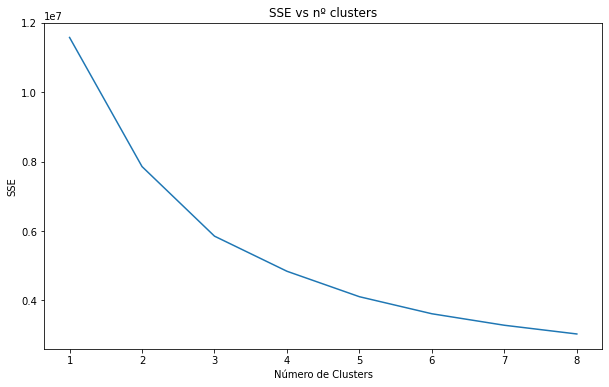

In [10]:
plt.figure(1, figsize= (10,6))
plt.plot(range(1, 9), sse)
plt.xticks(range(1, 9))
plt.xlabel("Número de Clusters")
plt.ylabel("SSE")
plt.title('SSE vs nº clusters')
plt.show()

Observamos que el punto de inflexión se produce en el 3. Por tanto, lo más adecuado sería utilizar **3 clusters**   
Igualmente utilizaremos KneeLocator para encontrar el punto de inflexión

In [11]:
kn = KneeLocator(x=range(1, 9), y=sse, curve='convex', direction='decreasing')
print('k óptimo: ', kn.knee)

k óptimo:  3


Utilizaremos **K=3** en el algoritmo **K-means**

In [12]:
kmeans3 = KMeans(n_clusters=3, random_state=0)
kmeans3.fit(x_pca)

KMeans(n_clusters=3, random_state=0)

Añadimos en airlines1 la columna con los clusters

In [13]:
airlines1['Cluster'] = kmeans3.labels_

In [14]:
#Porcentaje de datos en cada cluster
airlines1.Cluster.value_counts(normalize=True)

0    0.716678
2    0.180643
1    0.102679
Name: Cluster, dtype: float64

###### Observamos que el cluster 0 tiene el 71.6% de los datos

Analizamos las medias de cada una de las variables en los 3 clusters

In [15]:
#Medias por cluster
airlines1.groupby('Cluster').agg('mean')

,Month,DayofMonth,DayOfWeek,CRSDepTime,ActualElapsedTime,CRSElapsedTime,ArrDelay,DepDelay,Distance
Cluster,,,,,,,,,
0,6.099208,15.733970,3.974136,14.400053,104.060394,105.708612,27.244567,28.892782,537.019701
1,6.136220,15.900264,4.021353,15.078862,128.749150,122.947299,165.970349,160.168492,648.853224
2,6.126035,15.739610,4.007432,14.019980,251.923493,253.619084,31.181101,32.876692,1735.216035


#### Del análisis de las medias de cada variable por cluster observamos:
- **Month, DayofMonth, DayOfWeek y CRSDepTime** sus medias no presentan diferencias sensibles entre los clusters
- Las medias por cluster de **ActualElapsedTime y CRSElapsedTime** son muy similares. Trabajaremos con ActualElapsedTime
- Las medias por cluster de **ArrDelay y DepDelay** son muy similares. Trabajaremos con ArrDelay
- Cluster 0: Presenta **ArrDelay, Distance y ActualElapsedTime** bajos
- Cluster 1: Presenta **ArrDelay** altos y **Distance y ActualElapsedTime** medios
- Cluster 2: Presenta **ArrDelay** bajos y **Distance y ActualElapsedTime** altos

In [16]:
#Mediana por cluster
airlines1.groupby('Cluster').agg('median')

,Month,DayofMonth,DayOfWeek,CRSDepTime,ActualElapsedTime,CRSElapsedTime,ArrDelay,DepDelay,Distance
Cluster,,,,,,,,,
0,6.0,16.0,4.0,15.0,100.0,101.0,20.0,21.0,496.0
1,6.0,16.0,4.0,16.0,121.0,115.0,143.0,138.0,589.0
2,6.0,16.0,4.0,14.0,237.0,240.0,21.0,21.0,1616.0


Del análisis de las medianas de cada variable por cluster obtenemos conclusiones similares a las obtenidas del análisis de las medias

Analizamos gráficamente distribuciones y relaciones entre **ArrDelay, Distance y ActualElapsedTime** ya que son las variables que tienen variación sensible entre clusters

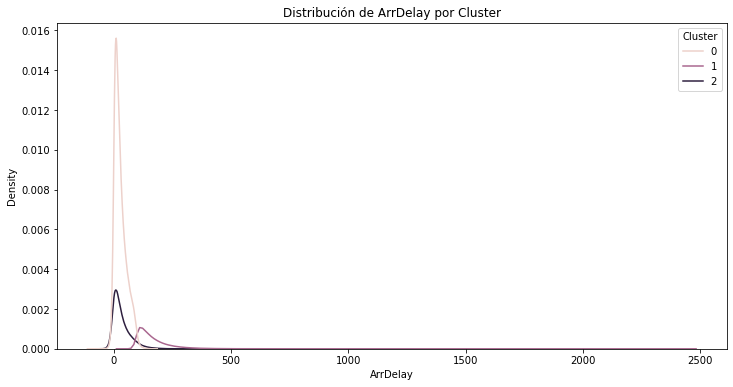

In [17]:
#Distribución de ArrDelay por Cluster
plt.figure(figsize=(12,6))
sns.kdeplot(x ='ArrDelay', data= airlines1, hue = airlines1['Cluster']).set(title='Distribución de ArrDelay por Cluster');

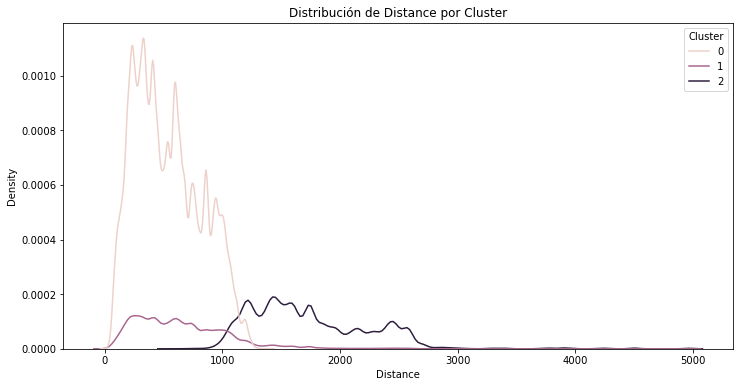

In [15]:
#Distribución de Distance por Cluster
plt.figure(figsize=(12,6))
sns.kdeplot(x ='Distance', data= airlines1, hue = airlines1['Cluster']).set(title='Distribución de Distance por Cluster');

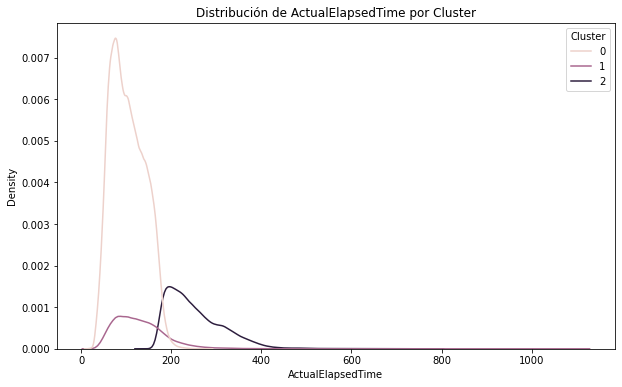

In [16]:
#Distribución de ActualElapsedTime por Cluster
plt.figure(figsize=(10,6))
sns.kdeplot(x ='ActualElapsedTime', data= airlines1, hue = airlines1['Cluster']).set(title='Distribución de ActualElapsedTime por Cluster');

Del análisis de las distribuciones de ArrDelay, Distance y ActualElapsedTime obtenemos conclusiones similiares a las del análisis de las medias:
- Cluster 0: Presenta **ArrDelay, Distance y ActualElapsedTime** bajos
- Cluster 1: Presenta **ArrDelay** altos y **Distance y ActualElapsedTime** bajos-medios
- Cluster 2: Presenta **ArrDelay** bajos y **Distance y ActualElapsedTime** altos

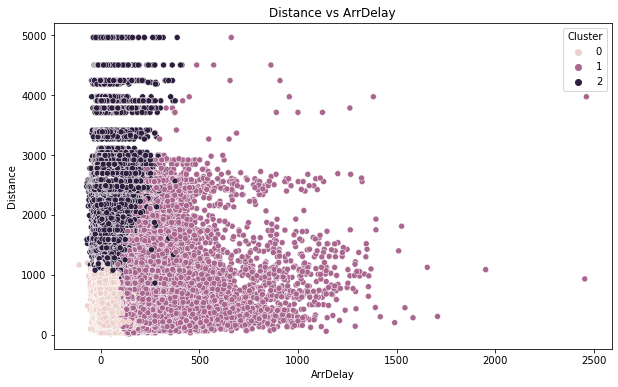

In [20]:
plt.figure(figsize=(10,6))
sns.scatterplot(x ='ArrDelay', y='Distance', data= airlines1, hue = airlines1['Cluster']).set(title='Distance vs ArrDelay');

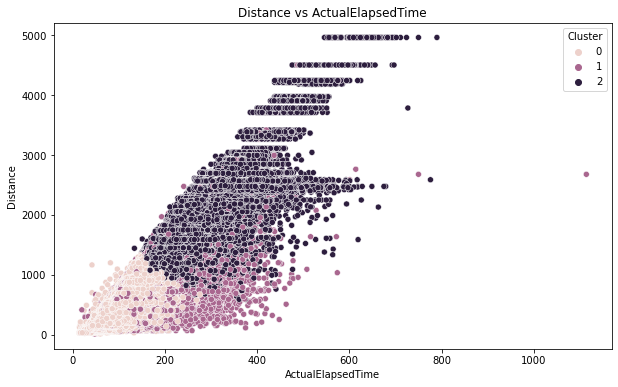

In [24]:
plt.figure(figsize=(10,6))
sns.scatterplot(x ='ActualElapsedTime', y='Distance', data= airlines1, hue = airlines1['Cluster']).set(title='Distance vs ActualElapsedTime');
                                                                                                       

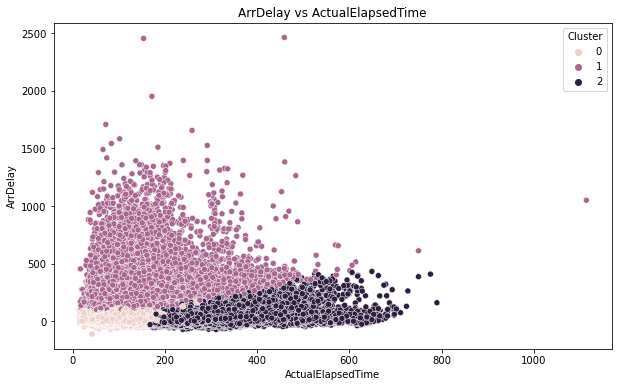

In [26]:
plt.figure(figsize=(10,6))
sns.scatterplot(x ='ActualElapsedTime', y='ArrDelay', data= airlines1, hue = airlines1['Cluster']).set(title='ArrDelay vs ActualElapsedTime');


Del análisis de las medias, medianas, distribuciones y gráficos entre 2 variables concluímos:
- Cluster 0: Vuelos de poco retraso, corta distancia y poca duración del vuelo
- Cluster 1: Vuelos con muchos retrasos y de corta-media distancia
- Cluster 2: Vuelos de larga distancia y poco-medio retraso 

## - Exercici 2

Agrupa els diferents vols utilitzant l'algorisme de clustering jeràrquic.

Para aplicar el clustering jerárquico y por motivos de rendimiento, trabajaremos con una **muestra del 2%** de los datos 

In [18]:
airlines2= airlines1.sample(frac=0.02, random_state = 0)
airlines2.drop('Cluster', axis=1, inplace=True)
airlines2

,Month,DayofMonth,DayOfWeek,CRSDepTime,ActualElapsedTime,CRSElapsedTime,ArrDelay,DepDelay,Distance
6731208,12,1,1,15,50.0,60.0,84.0,94.0,276
609057,2,3,7,10,119.0,130.0,7.0,18.0,697
889032,2,2,6,19,48.0,55.0,1.0,8.0,197
5502092,10,2,4,18,124.0,128.0,31.0,35.0,817
1699584,3,25,2,18,151.0,155.0,62.0,66.0,1103
...,...,...,...,...,...,...,...,...,...
2540655,5,2,5,16,167.0,141.0,34.0,8.0,508
6151125,11,29,6,10,216.0,227.0,116.0,127.0,1739
5194754,9,30,2,13,62.0,55.0,42.0,35.0,190
2048731,4,5,6,11,118.0,114.0,45.0,41.0,544


Aplicaremos **PCA** al data set airlines2.  
Previamente les aplicamos un escalado con:
- **StandardScaler** para CRSDepTime, ActualElapsedTime, CRSElapsedTime, ArrDelay, DepDelay, Distance ya que presentan muchos outliers.
- **MinMaxScaler** para Month, DayofMonth, DayOfWeek

In [19]:
#Escalamos con el MinMaxScaler y StandardScaler
columnas_standard= ['CRSDepTime', 'ActualElapsedTime', 'CRSElapsedTime', 'ArrDelay', 'DepDelay', 'Distance']
columnas_minmax= ['Month', 'DayofMonth', 'DayOfWeek']
x_minmax= MinMaxScaler().fit_transform(airlines2[columnas_minmax])
x_standard= StandardScaler().fit_transform(airlines2[columnas_standard])
airlines2_pca= pd.DataFrame(np.concatenate((x_minmax, x_standard), axis=1), columns = (columnas_minmax + columnas_standard))
airlines2_pca

,Month,DayofMonth,DayOfWeek,CRSDepTime,ActualElapsedTime,CRSElapsedTime,ArrDelay,DepDelay,Distance
0,1.000000,0.000000,0.000000,0.142177,-1.158060,-1.041439,0.725478,0.940216,-0.851585
1,0.090909,0.066667,1.000000,-1.038105,-0.198102,-0.058085,-0.619134,-0.470592,-0.119105
2,0.090909,0.033333,0.833333,1.086403,-1.185885,-1.111679,-0.723909,-0.656225,-0.989033
3,0.818182,0.033333,0.500000,0.850347,-0.128539,-0.086181,-0.200034,-0.155017,0.089678
4,0.181818,0.800000,0.166667,0.850347,0.247097,0.293112,0.341303,0.420445,0.587276
...,...,...,...,...,...,...,...,...,...
38562,0.363636,0.033333,0.666667,0.378234,0.469696,0.096442,-0.147647,-0.656225,-0.447938
38563,0.909091,0.933333,0.833333,-1.038105,1.151405,1.304562,1.284277,1.552804,1.693825
38564,0.727273,0.966667,0.166667,-0.329936,-0.991111,-1.111679,-0.007947,-0.155017,-1.001212
38565,0.272727,0.133333,0.833333,-0.802049,-0.212014,-0.282852,0.044441,-0.043637,-0.385303


In [20]:
#Aplicamos el PCA
pca = PCA(0.95)
x_pca2 = pca.fit_transform(airlines2_pca)
num_var = pca.n_components_                     #Calculo en nº de componentes
var_pca=[f'PCA_{i}' for i in range(num_var)]    #Creo los nombres de los componentes

x_pca2=pd.DataFrame(x_pca2, columns=var_pca)      
x_pca2

,PCA_0,PCA_1,PCA_2,PCA_3
0,-1.760033,1.180346,-0.009320,0.456619
1,-0.193088,-0.845346,0.973348,-0.445380
2,-1.926873,-0.894312,-1.115366,-0.257691
3,-0.093289,-0.192488,-0.864671,-0.000033
4,0.630621,0.590412,-0.824207,0.329663
...,...,...,...,...
38562,0.056518,-0.519143,-0.412813,-0.068941
38563,2.429360,1.909444,1.114921,-0.445829
38564,-1.784511,-0.134870,0.373011,0.261031
38565,-0.488007,-0.052824,0.808436,-0.286082


Hacemos un **dendograma** a partir de las PCA's para determinar el número óptimo de clusters

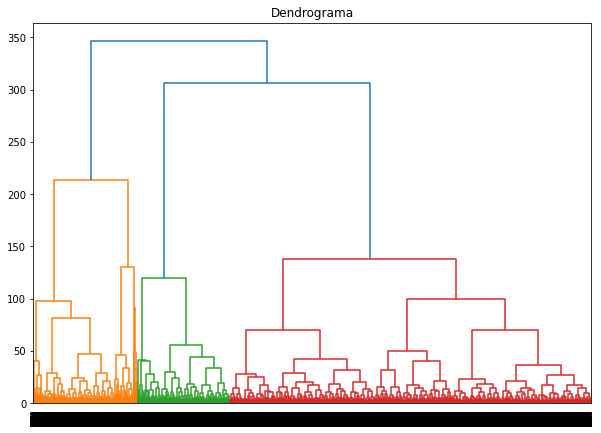

In [21]:
#Dendograma
plt.figure(figsize=(10, 7))  
plt.title("Dendrograma")  
dend = shc.dendrogram(shc.linkage(x_pca2, method='ward'))

Del dendograma observamos que el número óptimo de clusters es **3**

In [21]:
#Aplicamos Agglomerative Hierarchical Clustering con 3 clusters
ahc3 = AgglomerativeClustering(n_clusters=3)  
ahc3.fit_predict(x_pca2)

array([0, 0, 0, ..., 0, 0, 1], dtype=int64)

In [22]:
airlines2['Cluster']= ahc3.labels_

In [37]:
airlines2

,Month,DayofMonth,DayOfWeek,CRSDepTime,ActualElapsedTime,CRSElapsedTime,ArrDelay,DepDelay,Distance,Cluster
6731208,12,1,1,15,50.0,60.0,84.0,94.0,276,0
609057,2,3,7,10,119.0,130.0,7.0,18.0,697,0
889032,2,2,6,19,48.0,55.0,1.0,8.0,197,0
5502092,10,2,4,18,124.0,128.0,31.0,35.0,817,1
1699584,3,25,2,18,151.0,155.0,62.0,66.0,1103,1
...,...,...,...,...,...,...,...,...,...,...
2540655,5,2,5,16,167.0,141.0,34.0,8.0,508,1
6151125,11,29,6,10,216.0,227.0,116.0,127.0,1739,1
5194754,9,30,2,13,62.0,55.0,42.0,35.0,190,0
2048731,4,5,6,11,118.0,114.0,45.0,41.0,544,0


In [23]:
#Porcentaje de datos en cada cluster
airlines2.Cluster.value_counts(normalize=True)

0    0.707600
1    0.272642
2    0.019758
Name: Cluster, dtype: float64

Observamos una distribución de datos por cluster similar a k-means: 70.7% en el cluster 0

Analizamos las medias de cada una de las variables en los 3 clusters

In [24]:
#Medias por cluster
airlines2.groupby('Cluster').agg('mean')

,Month,DayofMonth,DayOfWeek,CRSDepTime,ActualElapsedTime,CRSElapsedTime,ArrDelay,DepDelay,Distance
Cluster,,,,,,,,,
0,6.092305,15.749579,3.959949,14.026603,100.036350,101.173507,36.797911,37.935068,501.658630
1,6.114693,15.575654,4.052592,15.348264,218.722111,219.564051,39.432810,40.274750,1451.170899
2,6.170604,15.755906,4.087927,14.570866,142.755906,135.742782,286.763780,279.750656,750.721785


#### Del análisis de las medias de cada variable por cluster observamos:
- Los clusters siguen un criterio de agrupación parecidos a k-means, pero con ciertas diferencias en los datos de cada cluster
- **Month, DayofMonth, DayOfWeek y CRSDepTime** sus medias no presentan diferencias sensibles entre los clusters
- Las medias por cluster de **ActualElapsedTime y CRSElapsedTime** son muy similares. Trabajaremos con ActualElapsedTime
- Las medias por cluster de **ArrDelay y DepDelay** son muy similares. Trabajaremos con ArrDelay
- Cluster 0: Presenta **ArrDelay, Distance y ActualElapsedTime** bajos
- Cluster 1: Presenta **ArrDelay** bajos y **Distance y ActualElapsedTime** altos
- Cluster 2: Presenta **ArrDelay** altos y **Distance y ActualElapsedTime** medios

In [25]:
#Mediana por cluster
airlines2.groupby('Cluster').agg('median')

,Month,DayofMonth,DayOfWeek,CRSDepTime,ActualElapsedTime,CRSElapsedTime,ArrDelay,DepDelay,Distance
Cluster,,,,,,,,,
0,6.0,16.0,4.0,14.0,95.0,95.0,23.0,23.0,446.0
1,6.0,16.0,4.0,16.0,205.0,205.0,27.0,26.0,1332.0
2,6.0,15.0,4.0,15.0,139.0,135.0,252.5,247.0,732.5


Del análisis de las medianas de cada variable por cluster obtenemos conclusiones similares a las obtenidas del análisis de las medias

Analizamos gráficamente las relaciones entre **ArrDelay, Distance y ActualElapsedTime** ya que son las variables que tienen variación sensible entre clusters

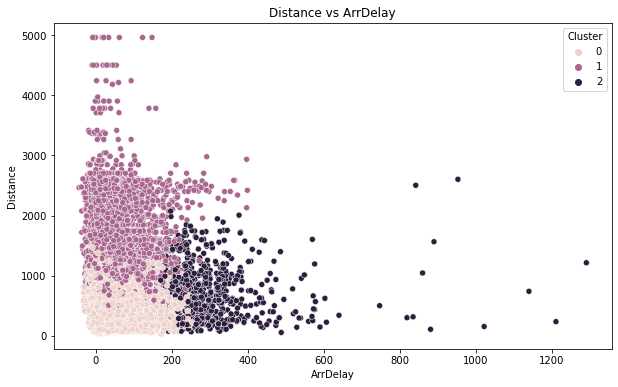

In [26]:
plt.figure(figsize=(10,6))
sns.scatterplot(x ='ArrDelay', y='Distance', data= airlines2, hue = airlines2['Cluster']).set(title='Distance vs ArrDelay');

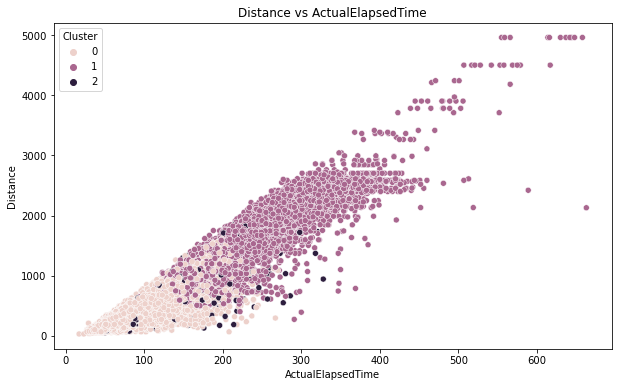

In [27]:
plt.figure(figsize=(10,6))
sns.scatterplot(x ='ActualElapsedTime', y='Distance', data= airlines2, hue = airlines2['Cluster']).set(title='Distance vs ActualElapsedTime');

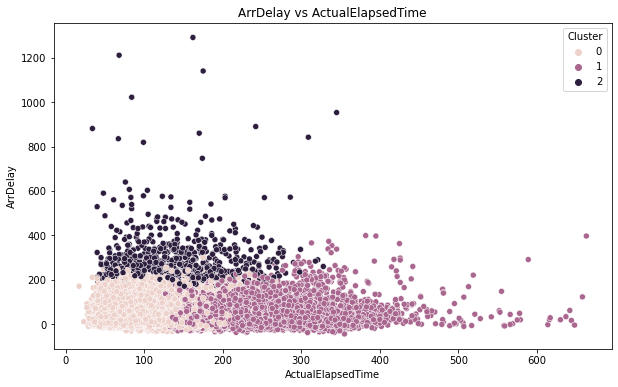

In [28]:
plt.figure(figsize=(10,6))
sns.scatterplot(x ='ActualElapsedTime', y='ArrDelay', data= airlines2, hue = airlines2['Cluster']).set(title='ArrDelay vs ActualElapsedTime');


Del análisis de las medias, medianas y gráficos entre 2 variables concluímos:
- Los clusters presentan contornos menos definidos y más contaminados con datos de otros clusters que en K-means
- Cluster 0: Vuelos de poco retraso, corta distancia y poca duración del vuelo
- Cluster 1: Vuelos de larga distancia y poco-medio retraso
- Cluster 2: Vuelos con muchos retrasos y de corta-media distancia

## - Exercici 3

Calcula el rendiment del clustering mitjançant un paràmetre com pot ser silhouette

Anteriormente hemos determinado el valor óptimo de k (número de clusters) mediante SSE. Nos daba un k=3.
Ahora vamos a determinar la bondad del clustering mediante el **silhouette coeficcient**. Representaremos el silhouette coefficient para valores de K entre 1 y 8.   
Trabajaremos con la **muestra del 2%** de los datos del ejercicio anterior por motivos de rendimiento

In [29]:
silhouette = []

for k in range(2, 9):
    kmeans = KMeans(n_clusters=k, random_state=0)       #Aplicamos KMeans para k entre 2 y 8
    kmeans.fit(x_pca2)
    s_coef = silhouette_score(x_pca2, kmeans.labels_)
    silhouette.append(s_coef)

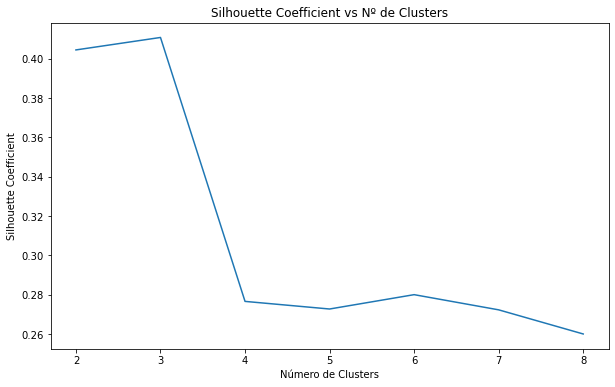

In [30]:
plt.figure(1, figsize= (10,6))
plt.plot(range(2, 9), silhouette)
plt.xticks(range(2, 9))
plt.xlabel("Número de Clusters")
plt.ylabel("Silhouette Coefficient")
plt.title('Silhouette Coefficient vs Nº de Clusters')
plt.show()

Según el gráfico de silhouette coefficient, el número óptimo de clusters sería 3 ya que presenta el mejor coeficiente. Este número coincide con el obtenido mediante la inertia o SSE.
En cuanto a la interpretación de los valores tendríamos:
- 1 Si los clusters están separados y bien distinguidos entre ellos
- 0 Si los clusters no están separados ni se distinguen

En el dataset tenemos un coeficiente máximo de 0.41 que nos indica un rendimiento discreto

### Conclusiones finales:
Trabajamos un data set con los vuelos en USA del 2008. El objetivo es realizar una agrupación (clustering) en función de las variables más significativas. 

Planteamos 2 modelos de clustering utilizando 9 variables numéricas: K-means y Agglomerative Clustering (clustering jerárquico).
- Utilizamos la **inertia o SSE** (Sum of squared error) para obtener el nº de clusters óptimo. Obtenemos k=3
- Utilizamos **silhouette** para obtener el número de clusters que presenten mejor definición y separación entre ellos. Obtenemos k=3
- k-means y agglomerative utilizan criterios parecidos para realizar el clustering. Podemos apreciar mayor definición de contornos y menor contaminación entre contornos en el modelo k-means

En cuanto al contenido de los clusters observamos los siguientes criterios de agrupación:
- **Cluster 0**: Vuelos de poco retraso, corta distancia y poca duración del vuelo
- **Cluster 1**: Vuelos de larga distancia y poco-medio retraso
- **Cluster 2**: Vuelos con muchos retrasos y de corta-media distancia

En cuanto a la bondad del clustering, es decir clusters separados y que se distingan bien, tenemos un coeficiente silhouette de 0.41, se trata de un rendimiento medio (mínimo=0, máximo=1)